In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.2 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install optimum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.4/418.4 kB 9.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.2 MB/s eta 0:00:00


In [7]:
sentences = ["ONNX is seriously fast for small batches. Impressive"]

from transformers import AutoTokenizer, pipeline
from optimum.onnxruntime import ORTModelForSequenceClassification

model_id = "SamLowe/roberta-base-go_emotions-onnx"
file_name = "onnx/model_quantized.onnx"

model = ORTModelForSequenceClassification.from_pretrained(model_id, file_name=file_name)
tokenizer = AutoTokenizer.from_pretrained(model_id)

onnx_classifier = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    function_to_apply="sigmoid",  # optional as is the default for the task
)

model_outputs = onnx_classifier(sentences)
# gives a list of outputs, each a list of dicts (one per label)

print(model_outputs)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

The ONNX file onnx/model_quantized.onnx is not a regular name used in optimum.onnxruntime, the ORTModel might not behave as expected.


model_quantized.onnx:   0%|          | 0.00/125M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

[[{'label': 'admiration', 'score': 0.9203393459320068}, {'label': 'approval', 'score': 0.0560273639857769}, {'label': 'neutral', 'score': 0.04265536740422249}, {'label': 'gratitude', 'score': 0.015126707963645458}, {'label': 'realization', 'score': 0.0072234803810715675}, {'label': 'optimism', 'score': 0.006548725999891758}, {'label': 'excitement', 'score': 0.00589498458430171}, {'label': 'disapproval', 'score': 0.004500020295381546}, {'label': 'surprise', 'score': 0.0038696150295436382}, {'label': 'pride', 'score': 0.003565720049664378}, {'label': 'annoyance', 'score': 0.00337585317902267}, {'label': 'joy', 'score': 0.0027169708628207445}, {'label': 'disappointment', 'score': 0.0025773176457732916}, {'label': 'curiosity', 'score': 0.0024763683322817087}, {'label': 'confusion', 'score': 0.0017749977996572852}, {'label': 'amusement', 'score': 0.0012000387068837881}, {'label': 'caring', 'score': 0.0011588273337110877}, {'label': 'anger', 'score': 0.001134643447585404}, {'label': 'love', 

In [20]:
[x['label'] for x in model_outputs[0]]

['admiration',
 'approval',
 'neutral',
 'gratitude',
 'realization',
 'optimism',
 'excitement',
 'disapproval',
 'surprise',
 'pride',
 'annoyance',
 'joy',
 'disappointment',
 'curiosity',
 'confusion',
 'amusement',
 'caring',
 'anger',
 'love',
 'sadness',
 'desire',
 'disgust',
 'relief',
 'fear',
 'embarrassment',
 'grief',
 'remorse',
 'nervousness']

In [10]:
model_outputs[0][0]

{'label': 'admiration', 'score': 0.9203393459320068}

In [68]:
emotions_weights = {
  "admiration": 5,
  "approval": 4,
  "gratitude": 1,
  "realization": 2,
  "optimism": 3,
  "excitement": 3,
  "surprise": 2,
  "pride": 2,
  "joy": 2,
  "amusement": 2,
  "caring": 1,
  "love": 1,
  "relief": 1,
  "neutral": 1,
  "curiosity": 1,
  "confusion": 1,
  "disappointment": -2,
  "annoyance": -2,
  "anger": -3,
  "sadness": -2,
  "embarrassment": -2,
  "disgust": -3,
  "fear": -4,
  "nervousness": -5,
  "grief": -5,
  "remorse": -5,
  "desire": -5,
  "disapproval": -5
}



In [27]:
import numpy as np

def normalize(values):
    min_val = min(values)
    max_val = max(values)
    
    # Normalize values to range [0, 1]
    normalized = [(value - min_val) / (max_val - min_val) for value in values]
    
    # Scale to range [-1, 1]
    scaled = [(2 * val) - 1 for val in normalized]
    
    return scaled

In [112]:
from transformers import pipeline

# Load the sentiment analysis model (SiBERT)
sentiment_analysis = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# # Load the emotion analysis model (RoBERTa)
# emotion_analysis = pipeline("emotion-analysis", model="roberta-base")

def get_sentiment_weighted_average(sentences, sentiment_weight=0.7, emotion_weight=0.3):
    sentiments = []
    emotions = []
    emotion_label = []
    emotion_weight_score = []
    # Analyze each sentence for sentiment and emotion
    for sentence in sentences:
        sentiment = sentiment_analysis(sentence)[0]
        top_emotion = onnx_classifier(sentence)[0][0]
        emotion = top_emotion['label']
        emotion_label.append(emotion)
        emotion_weight_score.append(emotions_weights[emotion]/5)
        sentiments.append(sentiment['score'])
        emotions.append(top_emotion['score'])
    
    sentiments = normalize(sentiments)
    # Apply weighted averaging
    
    weighted_sentiment = sum(sentiments[i] * sentiment_weight for i in range(len(sentiments)))
    weighted_emotion = sum(emotions[i] *  emotion_weight_score[i] for i in range(len(emotions)))
    
    print(sentiments)
    print(emotions)
    print(emotion_label)
    print(emotion_weight_score)
    # Combine weighted scores into an overall sentiment
    overall_sentiment = sum([sentiments[i] * sentiment_weight*emotions[i] *  emotion_weight_score[i] for i in range(len(sentiments)) if(emotion_weight_score[i]>(1/5))])/len(sentences)#weighted_sentiment + weighted_emotion

    return sentiments, emotion_weight_score, overall_sentiment





In [102]:
sentences = ["Customer: I'm having trouble with my internet connection. It keeps disconnecting frequently.",
    "Agent: I'm sorry to hear that. Let me check your connection status. Can you please provide me with your account number?",
    "Customer: Sure, my account number is 123456.",
    "Agent: Thank you. It seems there is an issue with the modem. I will guide you through the troubleshooting steps.",
    "Customer: I have a question about my latest bill. It seems higher than usual.",
    "Agent: Let me look into that for you. Can you please tell me the date of the bill you're referring to?",
    "Customer: It's the bill for May.",
    "Agent: I see. There was a charge for additional data usage last month. I can provide a detailed breakdown if you'd like.",
    "Customer: Yes, please. I'd like to understand the charges better.",
    "Agent: Certainly. Here is the breakdown: the base plan, additional data usage, and taxes.",
    "Customer: I'm interested in learning about any current offers or promotions.",
    "Agent: We have a special offer on our unlimited plan, which includes a discount for the first six months.",
    "Customer: That sounds great! Can you tell me more about the unlimited plan?",
    "Agent: The unlimited plan offers unlimited data with no speed throttling. It also includes access to premium support.",
    "Customer: I want to change my current plan. What other plans do you have?",
    "Agent: We offer a variety of plans, including a basic plan, a family plan, and an unlimited plan. Each plan has different data limits and pricing.",
    "Customer: I'm having issues with my SIM activation. It’s been more than 24 hours since I activated it.",
    "Agent: I'm sorry for the inconvenience. Let me check the activation status for you.",
    "Customer: Thank you. I really need it to be activated as soon as possible.",
    "Agent: It seems there was a delay in the activation process. I have escalated the issue, and it should be resolved within the next few hours.",
    "Customer: I appreciate your help. Will I get notified once it's activated?",
    "Agent: Yes, you will receive a confirmation message once the SIM is activated.",
    "Customer: I'm facing slow internet speeds even though I'm on an unlimited plan.",
    "Agent: I apologize for the inconvenience. Let's perform a speed test and check for any potential issues.",
    "Customer: I completed the speed test, and the results are lower than expected.",
    "Agent: I will escalate this issue to our technical team. They will investigate and get back to you with a solution.",
    "Customer: Can I get a refund for the downtime due to connectivity issues?",
    "Agent: We can certainly look into providing a credit for the downtime. Please give me a moment to check your account details.",
    "Customer: Thank you. I hope this gets resolved soon.",
    "Agent: I understand your concern. We will do our best to resolve this issue as quickly as possible."
]

In [113]:
sentences = [
    "Customer: I'm extremely frustrated with my internet connection. It keeps disconnecting every few minutes.",
    "Agent: I'm very sorry to hear that. I understand how disruptive this can be. Let's get this sorted out for you.",
    "Customer: This has been going on for weeks now. I'm considering switching to another provider.",
    "Agent: I apologize for the inconvenience. Could you please provide me with your account number so I can check the status?",
    "Customer: My account number is 789456.",
    "Agent: Thank you. Let me run a quick diagnostic test on your line.",
    "Agent: It appears that there is an issue with your modem's configuration. I'll walk you through some troubleshooting steps.",
    "Customer: I've already tried restarting it multiple times. Nothing seems to work.",
    "Agent: I understand. Let's try resetting the modem to its factory settings. This often resolves persistent issues.",
    "Customer: Alright, I'll give it a try.",
    "Agent: Please press and hold the reset button on your modem for 10 seconds, then release it.",
    "Customer: Done. It's rebooting now.",
    "Agent: Great. Once it's back online, please check if the connection is stable.",
    "Customer: It seems to be working better now. But why did this happen in the first place?",
    "Agent: Sometimes, configurations can get corrupted. A factory reset can help clear these issues.",
    "Customer: I hope it stays this way. But I also noticed an unexpected charge on my latest bill.",
    "Agent: Let me look into that for you. Could you please specify the charge you're referring to?",
    "Customer: It's a data overage fee for last month. I never exceed my limit.",
    "Agent: I see. Let me review your data usage for the last month.",
    "Agent: According to our records, there was an unusually high data usage on the 15th. Does that sound right?",
    "Customer: Not at all. I wasn't even home that day.",
    "Agent: In that case, it's possible that there was an error. I will escalate this issue to our billing department.",
    "Customer: How long will that take? I don't want to be charged unfairly.",
    "Agent: I understand your concern. I will expedite the process and ensure that the charges are reviewed within 24 hours.",
    "Customer: Thank you. I also wanted to ask about your current plans and offers.",
    "Agent: Absolutely. We have a new promotion on our unlimited data plan, which includes a 20% discount for the first six months.",
    "Customer: That sounds interesting. What are the benefits of the unlimited plan?",
    "Agent: The unlimited plan offers no data caps, no speed throttling, and priority customer support.",
    "Customer: That does sound better than my current plan. Can I switch to the unlimited plan?",
    "Agent: Certainly! I can process the change for you right now. Would you like to proceed?",
    "Customer: Yes, please.",
    "Agent: Done. Your new plan will take effect from the next billing cycle. Is there anything else I can assist you with?",
    "Customer: Actually, my SIM card hasn't been activated yet. It's been more than 24 hours.",
    "Agent: I apologize for the delay. Let me check the activation status for you.",
    "Agent: It seems there was a processing error. I have re-initiated the activation, and it should be completed within the next hour.",
    "Customer: Thank you. You've been really helpful.",
    "Agent: I'm glad I could assist you. Is there anything else you need help with today?",
    "Customer: No, that's all for now. Thank you for resolving my issues.",
    "Agent: You're welcome! If you have any further questions or concerns, please don't hesitate to contact us. Have a great day!",
    "Customer: Thank you. I appreciate your help. Have a good day!"
]


In [114]:
# Calculate the overall sentiment using weighted averaging
sentiments, emotion_weight_score, overall_sentiment = get_sentiment_weighted_average(sentences)
print("Overall Sentiment:", overall_sentiment)

[-0.33213116061772596, 0.11807621351864772, -0.6968728331109484, -0.0668031792395758, -0.9181352971274077, 0.17974709560893531, 0.10680669849901214, 0.3286737970437301, -0.58341469485307, -0.46282801932386197, -0.06201525174499356, -0.8243633284493423, -0.5576852025062436, 0.009797615642595625, -0.3115245693391684, -0.31468901173005437, -0.9544955023982675, -0.6468456009027072, -0.9092922050440397, -1.0, 1.0, -0.8420037806413265, -0.363206957357759, -0.5563363720785005, -0.8334091919035218, -0.6867447776680254, -0.6579880388545691, -0.39136996898176246, -0.289075951939637, -0.7544568799057974, -0.9248769524054329, -0.9710761029340018, -0.9761540605098419, -0.5920642145260653, -0.7929202303603673, 0.7324992241662474, -0.9912110503694992, -0.8296365668139223, 0.7989317510070069, 0.14417524124766556]
[0.6275986433029175, 0.7193440794944763, 0.8260671496391296, 0.6375946998596191, 0.9644445776939392, 0.9883098602294922, 0.8352462649345398, 0.5118231177330017, 0.6357802748680115, 0.71085137

In [95]:
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

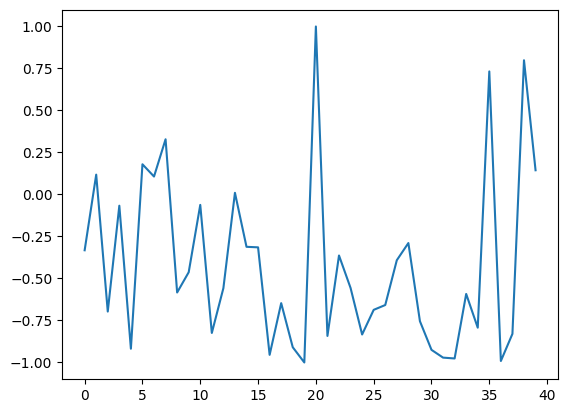

In [106]:
sns.lineplot(sentiments)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

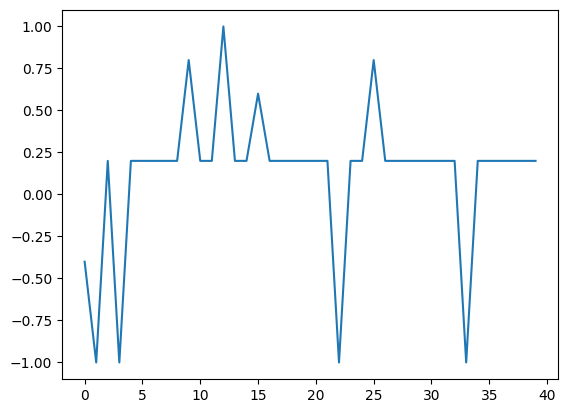

In [107]:
sns.lineplot(emotion_weight_score)

In [109]:
to_plot_values = [i for i in [sentiments[x]*emotion_weight_score[x] for x in range(len(sentiments))] if i!=0]

In [110]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats

# Example data
data = {
    'X': range(0,len(to_plot_values)),
    'Y': to_plot_values  # Intentionally adding an outlier
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate Z-scores for each column
z_scores = np.abs(stats.zscore(df))

# Define a threshold for identifying outliers
threshold = 3

# Remove outliers
df_clean = df[(z_scores < threshold).all(axis=1)]

# Separate the features and target variable
X = df_clean[['X']]
Y = df_clean['Y']

# Perform linear regression
model = LinearRegression()
model.fit(X, Y)

# Get the slope (coefficient) of the linear regression model
slope = model.coef_[0]
intercept = model.intercept_

print("Slope:", slope)
print("Intercept:", intercept)

# Example usage
print("Original DataFrame:")
print(df)
print("\nDataFrame after removing outliers:")
print(df_clean)


Slope: -0.0003509622244789235
Intercept: -0.09339923793889333
Original DataFrame:
     X         Y
0    0  0.132852
1    1 -0.118076
2    2 -0.139375
3    3  0.066803
4    4 -0.183627
5    5  0.035949
6    6  0.021361
7    7  0.065735
8    8 -0.116683
9    9 -0.370262
10  10 -0.012403
11  11 -0.164873
12  12 -0.557685
13  13  0.001960
14  14 -0.062305
15  15 -0.188813
16  16 -0.190899
17  17 -0.129369
18  18 -0.181858
19  19 -0.200000
20  20  0.200000
21  21 -0.168401
22  22  0.363207
23  23 -0.111267
24  24 -0.166682
25  25 -0.549396
26  26 -0.131598
27  27 -0.078274
28  28 -0.057815
29  29 -0.150891
30  30 -0.184975
31  31 -0.194215
32  32 -0.195231
33  33  0.592064
34  34 -0.158584
35  35  0.146500
36  36 -0.198242
37  37 -0.165927
38  38  0.159786
39  39  0.028835

DataFrame after removing outliers:
     X         Y
0    0  0.132852
1    1 -0.118076
2    2 -0.139375
3    3  0.066803
4    4 -0.183627
5    5  0.035949
6    6  0.021361
7    7  0.065735
8    8 -0.116683
9    9 -0.37026

In [48]:
import matplotlib.pyplot as plt

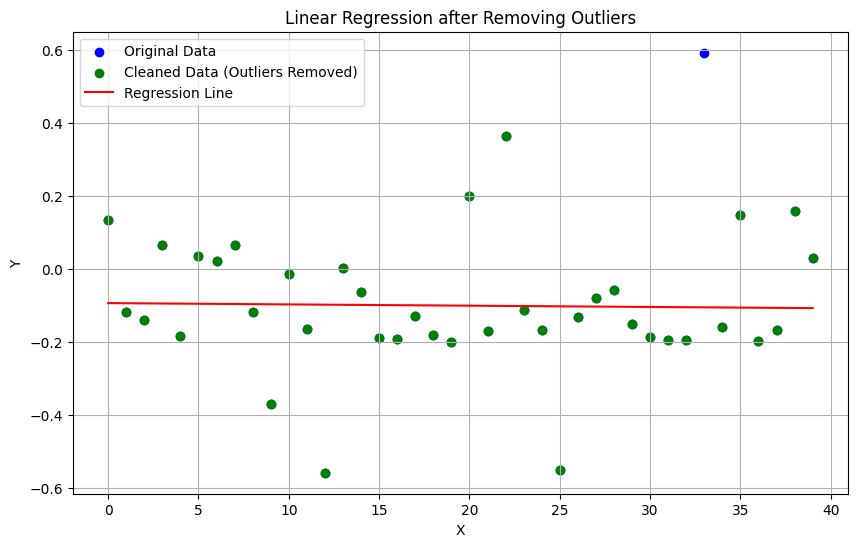

In [111]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot original data
plt.scatter(df['X'], df['Y'], color='blue', label='Original Data')

# Plot cleaned data
plt.scatter(df_clean['X'], df_clean['Y'], color='green', label='Cleaned Data (Outliers Removed)')

# Plot regression line
X_plot = np.linspace(df_clean['X'].min(), df_clean['X'].max(), 100)
Y_plot = slope * X_plot + intercept
plt.plot(X_plot, Y_plot, color='red', label='Regression Line')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression after Removing Outliers')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# interpretation
# slope shows how the conversation flowed throughout
# how to interpret the intercept?????